## Predicting Prices For Homes: In This Notebook We Are Cleaning Up Data 

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import math
import random

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import MinMaxScaler

#!pip install pygam 
from pygam import LinearGAM

from sklearn.model_selection import train_test_split
from sklearn import metrics

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('kc_house_data.csv')

## What Do We Have

In [3]:
df.head() # viewing data 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()
# note that we have 2 objects: date, and sqft_basement 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [5]:
df.columns # columns names 

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## What Are We Missing 

In [6]:
df.isna().sum()
# view, water front, year renovated 

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Cleaning of Water Front 

In [7]:
# waterfront is a float of what?

df['waterfront'].value_counts()

# looks like catagorical data so lets set the nulls to most common occurance == 0.00

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [8]:
df['waterfront'].fillna(0.0, inplace=True) # replacing nulls

## Cleaning of Veiw

In [9]:
df['view'].value_counts()
# looks like numerical data so lets set the NaNs values to the columns median

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [10]:
df['view'].median() # finding median 

0.0

In [11]:
df['view'].fillna(0.0, inplace=True) # replacing NaNs

## Cleaning of Year Removated 

In [12]:
df['yr_renovated'].value_counts() # looks like numerical data so lets set the NaNs values to the columns median

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [13]:
df['yr_renovated'].median() # finding median 

0.0

In [14]:
df['yr_renovated'].fillna(0.0, inplace=True) # replacing NaNs

In [15]:
df.isna().sum() # checking for NaNs

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Why is Square Foot Basement a Object and Not an Integer or Float 

In [16]:
df['sqft_basement'].unique() # looks like there is a string '?'

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [17]:
df['sqft_basement'].value_counts() # ? is ==  missing data 

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1816.0        1
1852.0        1
276.0         1
2390.0        1
2720.0        1
Name: sqft_basement, Length: 304, dtype: int64

When looking at the column names and their descriptions you can see that if you take the differnce between square foot above living and square foot living you are left with the basement.

In [18]:
df['sqft_basement']= df['sqft_living'] - df['sqft_above'] 
# differnce between square foot above living and square foot living

In [19]:
df['sqft_basement'].value_counts() # the missing data is no moreand the data type is now an integer

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

**Now lets look at id of the home to see if there are any repeats** 

In [20]:
df.loc[df['id'].duplicated() & df['price'].duplicated()] # veiwing repeats

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
372,2231500030,3/24/2015,530000.0,4,2.25,2180,10754,1.0,0.0,0.0,...,7,1100,1080,1954,0.0,98133,47.7711,-122.341,1810,6929
718,8820903380,1/2/2015,730000.0,6,2.25,2660,13579,2.0,0.0,0.0,...,7,2660,0,1937,1990.0,98125,47.7142,-122.286,1120,8242
1085,9834200885,4/20/2015,550000.0,4,2.50,2080,4080,1.0,0.0,0.0,...,7,1040,1040,1962,0.0,98144,47.5720,-122.290,1340,4080
1201,1231000510,5/4/2015,510000.0,3,1.75,1490,3800,1.0,0.0,0.0,...,6,700,790,1913,0.0,98118,47.5554,-122.270,2180,4000
1233,6117501820,4/28/2015,435000.0,2,1.00,790,11234,1.0,0.0,0.0,...,6,790,0,1942,0.0,98166,47.4413,-122.349,1930,11871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20165,7853400250,2/19/2015,645000.0,4,3.50,2910,5260,2.0,0.0,0.0,...,9,2910,0,2012,0.0,98065,47.5168,-121.883,2910,5260
20597,2724049222,12/1/2014,220000.0,2,2.50,1000,1092,2.0,0.0,0.0,...,7,990,10,2004,0.0,98118,47.5419,-122.271,1330,1466
20654,8564860270,3/30/2015,502000.0,4,2.50,2680,5539,2.0,0.0,0.0,...,8,2680,0,2013,0.0,98045,47.4759,-121.734,2680,5992
20764,6300000226,5/4/2015,380000.0,4,1.00,1200,2171,1.5,0.0,0.0,...,7,1200,0,1933,0.0,98133,47.7076,-122.342,1130,1598


In [21]:
df.loc[df['id'] == 7853420110] # pricing is the target but the duplicated ids of the homes have different prices

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21564,7853420110,10/3/2014,594866.0,3,3.0,2780,6000,2.0,0.0,0.0,...,9,2780,0,2013,0.0,98065,47.5184,-121.886,2850,6000
21565,7853420110,5/4/2015,625000.0,3,3.0,2780,6000,2.0,0.0,0.0,...,9,2780,0,2013,0.0,98065,47.5184,-121.886,2850,6000


In [22]:
df.loc[df['id'] == 8820903380] # prices are different so we can keep the repeats in this case

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
717,8820903380,7/28/2014,452000.0,6,2.25,2660,13579,2.0,0.0,0.0,...,7,2660,0,1937,1990.0,98125,47.7142,-122.286,1120,8242
718,8820903380,1/2/2015,730000.0,6,2.25,2660,13579,2.0,0.0,0.0,...,7,2660,0,1937,1990.0,98125,47.7142,-122.286,1120,8242


## Checking For Correlations

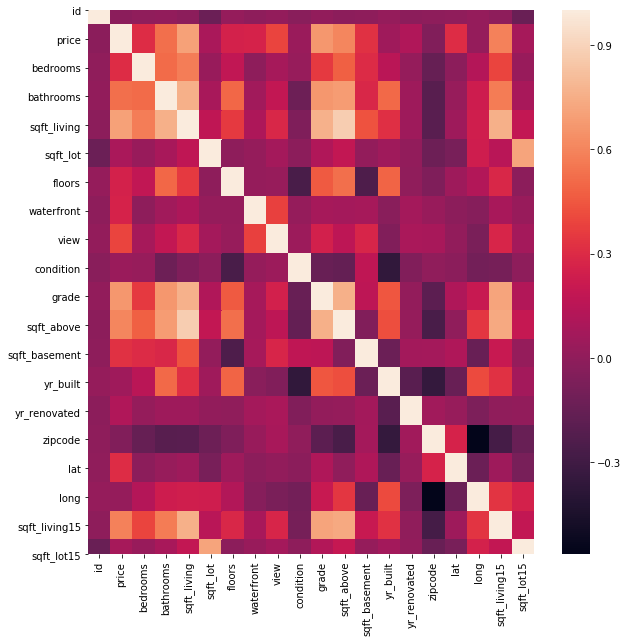

In [23]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr()) # heatmap plot

## Price vs Columns

Most correlated columns:
* sqft_living15
* sqft_above
* sqft_living
* grade
* bathroom

Second correlated columns:
* sqft_basement
* view
* waterfront
* floor
* bedroom

**Lets look at all of the columns to see if anything is off**

## Most Correlated Columns

In [24]:
df['bathrooms'].value_counts()  # outliers are here

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [25]:
df['grade'].value_counts() # outliers are here

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [26]:
df['sqft_living15'].value_counts()

1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

In [27]:
df['sqft_above'].value_counts()

1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

In [28]:
df['sqft_living'].value_counts()

1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

## Second Correlated Columns

In [29]:
df['sqft_basement'].value_counts()

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

In [30]:
df['view'].value_counts()

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [31]:
df['waterfront'].value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

In [32]:
df['floors'].value_counts() # the 7 houses that have 3.5 floors may act as an outlier in this case

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [33]:
df['bedrooms'].value_counts() # outliers are here

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

## What Can You See So Far?

1. It looks like we could create a new column called house_sqft that has the basement and upperfloors combined 
2. When testing the models we could possibly tensor lat and long together
3. Four columns have outliers:
    - bedrooms
    - floors
    - bathrooms
    - grade
    

## Baseline Modeling 

In [34]:
mc_df = df[['sqft_living15', 'sqft_above', 'sqft_living', 'grade', 'bathrooms']] # subset of most correlated data

In [35]:
smc_df = df[['sqft_basement', 'view', 'waterfront', 'floors', 'bedrooms']] # subset of second most correlated data

In [36]:
mc_df.describe() # the scale of the data is too wide

,sqft_living15,sqft_above,sqft_living,grade,bathrooms
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,1986.620318,1788.596842,2080.321850,7.657915,2.115826
std,685.230472,827.759761,918.106125,1.173200,0.768984
min,399.000000,370.000000,370.000000,3.000000,0.500000
25%,1490.000000,1190.000000,1430.000000,7.000000,1.750000
50%,1840.000000,1560.000000,1910.000000,7.000000,2.250000
75%,2360.000000,2210.000000,2550.000000,8.000000,2.500000
max,6210.000000,9410.000000,13540.000000,13.000000,8.000000


## Run Model on subset

In [37]:
target = df['price'] 

In [38]:
model = LinearRegression()

In [39]:
scaler = RobustScaler() # this will even out the scale of the data so it is not to spread out for the model

In [40]:
pipe = make_pipeline(scaler, model) # creating a pipeline that tells the model to scale the data first then run model

In [41]:
preds = cross_validate(pipe, mc_df, target, cv=5, scoring="r2") 
# testing the model to see how well it predicts while cross validating

In [42]:
preds['test_score'].mean() # averaging the R^2 scores  for each cv ran

0.5414792741778219

In [43]:
preds['test_score'].std() # standard deviataion of R^2 scores

0.011948643078223785

## Findings

After I run linear regression model with a robust scaler and with a cv of 5 on the most corr vs price I get R^2 0.5414792741778219 and std on 1%, 0.011948643078223785.

I will create a subset dataframe that does not have dataes in it to try a new model.

In [44]:
X = df.drop(columns=['price', 'date']) # dropping unwanted column and target column

In [45]:
X.head() # viewing dataset that includes all columns but the two dropped

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [46]:
preds = cross_validate(pipe, X, target, cv=5, scoring="r2") 
# running the model on the whole dataframe to see if its R^2 will improve while cross validating

In [47]:
preds['test_score'].mean() # averaging the R^2 score for each cv ran

0.6946799966781807

In [48]:
preds['test_score'].std() # standard deviataion of R^2 scores

0.0068847872049776

## New Findings

 If I drop date and run a the linear model with a robust scaler and a cv of 5 I get a R^2 of 0.6946799966781807  and a std 0.0068847872049776,  0.6%.

When looking at the heatmap again I saw that there is multicollinearity. A model that will help take care of this is ridge.

## Ridge Model

In [49]:
model2 = Ridge(alpha=40) # setting the the new model to a variable

In [50]:
pipe2 = make_pipeline(scaler, model2)
# creating a pipeline that tells the model to scale the data first then run model

In [51]:
preds = cross_validate(pipe2, X, target, cv=5, scoring="r2")
# running the model on the whole dataframe to see if its R^2 will improve while cross validating

In [52]:
preds # the results return as a dictionary 

{'fit_time': array([0.05103827, 0.02910185, 0.02239895, 0.02321625, 0.02248001]),
 'score_time': array([0.00602198, 0.00390911, 0.00201225, 0.00204277, 0.0020721 ]),
 'test_score': array([0.6894657 , 0.69132592, 0.69181201, 0.71020285, 0.68619473])}

In [53]:
preds['test_score'].mean() # averaging the R^2 score for each cv ran

0.6938002425974055

In [54]:
preds['test_score'].std() # standard deviataion of R^2 scores

0.008435079371706853

## New Findings 


The model improved!!! After changing the alpha in the model around 40 was the best one that brought a very low std score. 


Now I want to try a new model that will get ride of the columns I do not need first then try to prdict the prices. Lasso is able to do this. 

In [55]:
model3 = Lasso(alpha=800) # setting the the new model to a variable

In [56]:
pipe3 = make_pipeline(scaler, model3)
# creating a pipeline that tells the model to scale the data first then run model

In [57]:
preds = cross_validate(pipe3, X, target, cv=5, scoring="r2")
# running the model on the whole dataframe to see if its R^2 will improve while cross validating 

In [58]:
preds

{'fit_time': array([0.09082198, 0.04976201, 0.06049085, 0.05451798, 0.05833387]),
 'score_time': array([0.00488305, 0.00229311, 0.00222802, 0.00252533, 0.00338507]),
 'test_score': array([0.68993424, 0.69139661, 0.6921772 , 0.70929463, 0.68649949])}

In [59]:
preds['test_score'].mean() # averaging the R^2 score for each cv ran

0.6938604361727876

In [60]:
preds['test_score'].std() # standard deviataion of R^2 scores

0.007958850286477453

## New Findings

Looks like the std score is way better with this model, but there is a small decrease in the R^2 average. Overall either one of the models above would be good a baseline model. I will go with lasso being that the std score is lower (even though there was a small change in the R^2 score in lasso, it still was about 71% like the ridge model). 

## Data Transforming

In [61]:
# Using mutiplcation below on bathrooms, lat, long are being manipulated
# Transforming the data to see if the model will improve

X['lon_times_lan'] = X['lat'] * X['long']
X['lon_times_lan_sq'] = X['lon_times_lan']**2
X['lon_times_lan_cubed'] = X['lon_times_lan']**3
X['bedroom_times_bathroom'] = X['bathrooms'] * X['bedrooms']
X['bedroom_times_bathroom_sq'] = X['bedroom_times_bathroom']**2
X['bedroom_times_bathroom_cubed'] = X['bedroom_times_bathroom']**3

X['lat_sq'] = X['lat']**2
X['long_sq'] = X['long']**2
X['lat_cube'] = X['lat']**3
X['long_sq'] = X['long']**3

In [62]:
X.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,lon_times_lan,lon_times_lan_sq,lon_times_lan_cubed,bedroom_times_bathroom,bedroom_times_bathroom_sq,bedroom_times_bathroom_cubed,lat_sq,long_sq,lat_cube
0,7129300520,3,1.00,1180,5650,1.0,0.0,0.0,3,7,...,5650,-5808.576778,3.373956e+07,-1.959788e+11,3.00,9.0000,27.000000,2257.314125,-1.827348e+06,107247.702877
1,6414100192,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,7639,-5837.184999,3.407273e+07,-1.988888e+11,6.75,45.5625,307.546875,2277.293841,-1.830129e+06,108674.739386
2,5631500400,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,8062,-5835.146731,3.404894e+07,-1.986805e+11,2.00,4.0000,8.000000,2278.907096,-1.826272e+06,108790.239078
3,2487200875,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,5000,-5816.213274,3.382834e+07,-1.967528e+11,12.00,144.0000,1728.000000,2258.226433,-1.833453e+06,107312.726660
4,1954400510,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,7503,-5811.392356,3.377228e+07,-1.962640e+11,6.00,36.0000,216.000000,2267.359642,-1.817858e+06,107964.410613


In [63]:
preds = cross_validate(pipe3, X, target, cv=5, scoring="r2")
# running the model on the whole dataframe to see if its R^2 will improve while cross validating 

In [64]:
preds['test_score'].mean() # averaging the R^2 score for each cv ran

0.7050328100909464

In [65]:
preds['test_score'].std() # standard deviataion of R^2 scores

0.008199276768314523

## New Findings 

No progress made here. So I will go back to transforming the data. 

## More Data Transforming

In [66]:
X_2 = X.drop(columns= ['sqft_above', 'sqft_basement']) # dropping columns that are interacting with one another

In [67]:
preds = cross_validate(pipe3, X_2, target, cv=5, scoring="r2")
# running the model on the whole dataframe to see if its R^2 will improve while cross validating 

In [68]:
preds['test_score'].mean() # averaging the R^2 score for each cv ran

0.7051485743405671

In [69]:
preds['test_score'].std() # standard deviataion of R^2 scores

0.008068927601907258

## New Findings

This seems to be the limbo for the R^2 so I will use this as my updated baseline model. 

## Next Step

GAMS model will helpus smooth out our predictor more

## GAMS

In [74]:
gam = LinearGAM(n_splines=25)
gam.gridsearch(X_2.values, target)
gam.summary()

# after running the model to smooth things out for the perdictor the R^2 score increased to .85

100% (11 of 11) |########################| Elapsed Time: 0:01:06 Time:  0:01:06


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    313.9579
Link Function:                     IdentityLink Log Likelihood:                               -532639.9936
Number of Samples:                        21597 AIC:                                           1065909.903
                                                AICc:                                         1065919.2553
                                                GCV:                                      21051236992.5724
                                                Scale:                                    20501116007.9304
                                                Pseudo R-Squared:                                   0.8503
Feature Function                  Lam

In [75]:
gam = LinearGAM(n_splines=60)
gam.gridsearch(X_2.values, target)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:04:44 Time:  0:04:44


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    652.6602
Link Function:                     IdentityLink Log Likelihood:                               -529728.2658
Number of Samples:                        21597 AIC:                                          1060763.8521
                                                AICc:                                         1060804.7191
                                                GCV:                                      18942931113.6173
                                                Scale:                                     17915367405.676
                                                Pseudo R-Squared:                                   0.8713
Feature Function                  Lam

In [76]:
gam = LinearGAM(n_splines=25)
gam.gridsearch(X_2.values, target)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:01:09 Time:  0:01:09


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    313.9579
Link Function:                     IdentityLink Log Likelihood:                               -532639.9936
Number of Samples:                        21597 AIC:                                           1065909.903
                                                AICc:                                         1065919.2553
                                                GCV:                                      21051236992.5724
                                                Scale:                                    20501116007.9304
                                                Pseudo R-Squared:                                   0.8503
Feature Function                  Lam

In [77]:
gam = LinearGAM(n_splines=70)
gam.gridsearch(X_2.values, target)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:06:06 Time:  0:06:06


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    742.3833
Link Function:                     IdentityLink Log Likelihood:                               -528899.0506
Number of Samples:                        21597 AIC:                                          1059284.8677
                                                AICc:                                         1059337.9413
                                                GCV:                                       18373794851.232
                                                Scale:                                    17240534463.1408
                                                Pseudo R-Squared:                                   0.8766
Feature Function                  Lam